# Imports

In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

# Representación de datos
Debido a que vamos a trabajar con la forma más simple del TSP, necesitamos una forma de representar los datos::

In [2]:
from math import sin, cos, sqrt, atan2, radians

def distance2points(lat1, lon1, lat2, lon2):
    # Radio aproximado de la tierra en km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    
    return distance


class City:
    def __init__(self,name, x, y):
        self.name = name
        self.x = x
        self.y = y

    def distance(self, city):
        return distance2points(self.x, self.y, city.x, city.y)

    def __repr__(self):
        return "(" + str(self.name)+ ")"



# ¿Cómo funciona el algoritmo?

## El concepto de individuo

Un individuo puede ser visto como una sola instancia del problema, para este caso es fácil ver que el individuo es la secuencia de "ciudades" y el orden en que son visitadas.

## Fitness (Aptitud física)
Los algoritmos genéticos imitan las estructuras naturales utilizando la idea de "supervivencia del más apto", por lo que es importante definir una función de aptitud común para todos los individuos. Para este caso, la aptitud de un individuo es la suma de la distancia para cada par de ciudades consecutivas, incluida la suma de la última ciudad de la secuencia y la primera (porque TSP forma un bucle).

>$Fitness=[\sum_{i=1}^{N-1} Distance(City_{i},City_{i+1})]+Distance(City_{N},City_{1})$

Esta función de "Distancia" es solo la distancia euclidiana entre cada ciudad.

In [3]:
#Create a fitness function

class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0

    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Mutación y reproducción
El algoritmo crea las próximas generaciones utilizando dos métodos, ya sea mutando individuos individuales en función de una probabilidad, o "apareando" dos individuos para crear uno nuevo. Aquí definimos todas las funciones necesarias para realizar el algoritmo.

In [4]:
#Create our initial population
#Route generator
#Este método aleatoriza el orden de las ciudades, lo que significa que este método crea un individuo al azar.

def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route


#Create first "population" (list of routes)
#Este método creó una población aleatoria del tamaño especificado.

def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population


#Create the genetic algorithm
#Rank individuals
#Esta función toma una población y la ordena en orden descendente usando la aptitud (fitness) de cada individuo

def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    sorted_results=sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)
    return sorted_results

#Cree una función de selección que se usará para hacer la lista de rutas principales
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

#Create mating pool
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

#Crear una función de cruce para que dos padres creen un hijo
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])


    childP2 = [item for item in parent2 if item not in childP1]
    # print(startGene, endGene)

    # print(parent1)
    # print(parent2)

    # print(childP1)
    # print(childP2)
    child = childP1 + childP2

    # print(child)
    return child

##Crear función para ejecutar el cruce sobre el grupo

def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])

    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children


#Crear función para mutar una sola ruta
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))

            city1 = individual[swapped]
            city2 = individual[swapWith]

            individual[swapped] = city2
            individual[swapWith] = city1
    return individual


#Crear función para ejecutar la mutación en toda la población
def mutatePopulation(population, mutationRate):
    mutatedPop = []

    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

#Pon todos los pasos juntos para crear la próxima generación
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

## El algoritmo genético
Con todas estas funciones definidas, solo queda escribir la definición del algoritmo genético.

In [5]:
#Paso final: crear el algoritmo genético
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = [1 / rankRoutes(pop)[0][1]]
    print("distancia Inicial: " + str(progress[0]))

    for i in range(1, generations+1):

        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        if i%50==0:
          print('Generacion '+str(i),"Distancia: ",progress[i])


    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]

    plt.plot(progress)
    plt.ylabel('Distancia')
    plt.xlabel('Generacion')
    plt.title('Mejor Fitness vs Generación')
    plt.tight_layout()
    plt.show()

    return bestRoute

## Pruebas
Sepa que creamos una lista de ciudades y ejecutamos el algoritmo, esto debería devolver la mejor ruta encontrada en la última generación.

distancia Inicial: 2720.3247358220974
Generacion 50 Distancia:  1242.7688675346035
Generacion 100 Distancia:  936.8328902662463
Generacion 150 Distancia:  857.4627179102523
Generacion 200 Distancia:  732.8701745849911
Generacion 250 Distancia:  714.1231373862632
Generacion 300 Distancia:  712.6180215686513
Generacion 350 Distancia:  678.0494390964343
Generacion 400 Distancia:  672.2562453602762
Generacion 450 Distancia:  677.2482157959669
Generacion 500 Distancia:  689.4311914144446
Generacion 550 Distancia:  678.0343264019826
Generacion 600 Distancia:  692.4764165783106
Generacion 650 Distancia:  657.7619499535907
Generacion 700 Distancia:  637.0620845523736
Generacion 750 Distancia:  642.4091523296418
Generacion 800 Distancia:  647.1462061967328


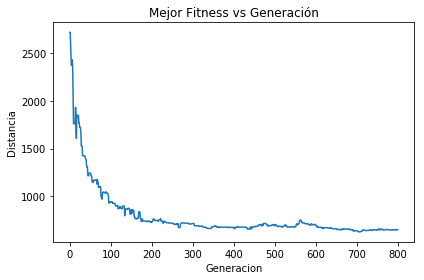

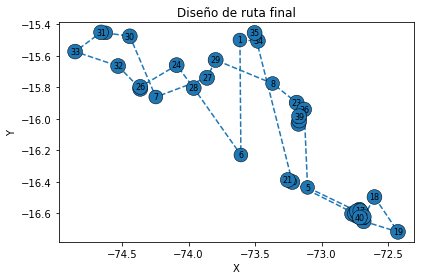

In [6]:
#Running the genetic algorithm
#lista de ciudades

cityList = []

# Lectura del archivo
file = './EESS_AQP_REDES.xlsx'
df = pd.read_excel(file, sheet_name='TB_EESS')

subset = df[df['red']=="CAMANA CARAVELLI"]

for i in range(0,len(subset.index)):
  cityList.append(City(name = i, x=subset['longitud'].values[i], y=subset['latitud'].values[i]))

best_route=geneticAlgorithm(population=cityList, popSize=150, eliteSize=20, mutationRate=0.01, generations=800)
x=[]
y=[]
for i in best_route:
  x.append(i.x)
  y.append(i.y)
x.append(best_route[0].x)
y.append(best_route[0].y)
plt.plot(x, y, '--o')
plt.xlabel('X')
plt.ylabel('Y')
ax=plt.gca()
plt.title('Diseño de ruta final')
bbox_props = dict(boxstyle="circle,pad=0.3", fc='C0', ec="black", lw=0.5)
for i in range(1,len(cityList)+1):
  ax.text(cityList[i-1].x, cityList[i-1].y, str(i), ha="center", va="center",
            size=8,
            bbox=bbox_props)
plt.tight_layout()
plt.show()

In [7]:
best_route

[(3),
 (16),
 (10),
 (20),
 (19),
 (34),
 (33),
 (0),
 (5),
 (27),
 (23),
 (25),
 (24),
 (31),
 (32),
 (30),
 (8),
 (29),
 (6),
 (26),
 (28),
 (7),
 (22),
 (36),
 (38),
 (21),
 (35),
 (4),
 (12),
 (13),
 (39),
 (9),
 (2),
 (14),
 (18),
 (17),
 (37),
 (11),
 (1),
 (15)]